In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
#from skimage.io import imsave
import os
#from tensorboardX import SummaryWriter

from tqdm import tqdm

In [2]:
use_gpu = torch.cuda.is_available()
def gpu(tensor, gpu=use_gpu):
    if gpu:
        return tensor.cuda()
    else:
        return tensor

In [3]:
img_height = 28
img_width = 28
img_size = img_height * img_width

to_train = True
to_restore = False
output_path = "output"

max_epoch = 1000

hg_size = 150
hd_size = 300
z_size = 100
batch_size = 256
seq_size=4
n_hidden=300
tr_data_num=60000;
g_num_layers=2;
d_num_layers=2;

In [4]:
root_dir = "/home/majrda/Scripts/data"

In [72]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.lstm_G = nn.LSTM(input_size = z_size, 
                           hidden_size = n_hidden,
                           num_layers = g_num_layers,
                           bias = False)

    self.MLP = nn.Linear(n_hidden, img_size)

  def forward(self, x):
    x = x.unsqueeze(1)
    #print(x.size())
    output, _ = self.lstm_G(x)
    output = torch.tanh(self.MLP(output))
    #print(output[0,:,0])
    return output

In [73]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.lstm_D = nn.LSTM(input_size = img_size, 
                           hidden_size = n_hidden,
                           num_layers = d_num_layers)

    self.MLP = nn.Linear(n_hidden, 1)

  def forward(self, x):
    outputs, _ = self.lstm_D(x)
    #print(outputs.size())
    res = self.MLP(outputs[:, -1, :])
    #print(res)
    y_data = torch.sigmoid(res.narrow(0, 0, x[0].shape[0]))
    return y_data

In [7]:
mnist_trainset = datasets.MNIST(root=root_dir, train=True, download=False, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root=root_dir, train=False, download=False, transform=transforms.ToTensor())

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset,
                                       batch_size=batch_size, 
                                       shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_testset,
                                        batch_size=batch_size, 
                                        shuffle=False)

In [9]:
lr = 1e-4
nb_epochs = 100

In [10]:
loss_D_epoch = []
loss_G_epoch = []

In [74]:
net_G = gpu(Generator())
net_D = gpu(Discriminator())

optimizer_G = torch.optim.Adam(net_G.parameters(),lr=lr)
optimizer_D = torch.optim.Adam(net_D.parameters(),lr=lr)

for e in range(nb_epochs):
    print("Epoch ",e)
    loss_G = 0
    loss_D = 0
    for t, real_batch in enumerate(tqdm(train_loader)):
            #improving D
        z = gpu(torch.empty(batch_size,z_size).normal_())
        fake_batch = net_G(z)
        #print(fake_batch.shape)
        #print(fake_batch.shape)
        D_scores_on_fake = net_D(fake_batch)
        #print(D_scores_on_fake)
        #print(real_batch[0])
        #print(real_batch[0].view(256, 1, 784))
        D_scores_on_real = net_D(real_batch[0].view(real_batch[0].shape[0], 1, 784).cuda())
        #print(D_scores_on_real)
            
        loss = -torch.mean(torch.log(1-D_scores_on_fake[0]) + torch.log(D_scores_on_real[0]))
        optimizer_D.zero_grad()
        loss.backward()
        optimizer_D.step()
        loss_D += loss
                    
            # improving G
        z = gpu(torch.empty(batch_size,z_size).normal_())
        fake_batch = net_G(z)
        D_scores_on_fake = net_D(fake_batch)
            
        loss = -torch.mean(torch.log(D_scores_on_fake[0]))
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()
        loss_G += loss
           
    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)
    print("Loss on Generator this epoch: {}\nLoss on Discriminator this epoch: {}".format(loss_G, loss_D))

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch  0


  0%|          | 1/235 [00:00<00:41,  5.64it/s]

Loss on Generator this epoch: 207.3694305419922
Loss on Discriminator this epoch: 182.0785675048828
Epoch  1


  0%|          | 1/235 [00:00<00:41,  5.61it/s]

Loss on Generator this epoch: 321.3842468261719
Loss on Discriminator this epoch: 80.41619873046875
Epoch  2


 22%|██▏       | 51/235 [00:10<00:36,  5.02it/s]

KeyboardInterrupt: 

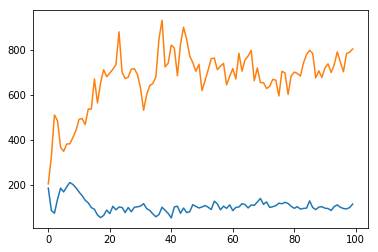

In [14]:
import matplotlib.pyplot as plt

plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)
plt.show()

In [28]:
z = gpu(torch.empty(batch_size,z_size).normal_())
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()

In [70]:
x = fake_data[0, 0]

x = x.reshape(28, 28)

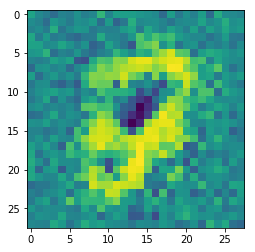

In [71]:
from matplotlib import pyplot as plt
plt.imshow(x, interpolation='nearest')
plt.show()